In [1]:
import fix_sys_path
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [2]:
root = os.getcwd()


In [3]:
exps = os.listdir(os.path.join(root, "logs"))
exps = list(sorted(exps))
exps

['Te19.0Nx1000_Np10000_h1e-05_tau5e-13_n1000000_23_05_2023_11_35_25',
 'Te20.0Nx1000_Np10000_h1e-05_tau5e-13_n1000000_22_05_2023_00_57_05',
 'Te21.0Nx1000_Np10000_h1e-05_tau5e-13_n1000000_23_05_2023_11_37_04',
 'Te25.0Nx1000_Np10000_h1e-05_tau5e-13_n2000000_23_05_2023_11_42_37',
 'Te30.0Nx1000_Np10000_h1e-05_tau5e-13_n1500000_23_05_2023_11_34_23',
 'Te35.0Nx1000_Np10000_h1e-05_tau5e-13_n2000000_23_05_2023_11_41_09']

In [4]:
iters = {
    30: 6000,
    19: 6000,
    20: 6000,
    21: 6000,
    25: 6000,
    35: 17500
}

In [5]:
temp_arr = []
sigma_arr = []
for path in exps:
    temp = float(path[2:4])
    temp_arr.append(temp)
    logpath = os.path.join(root, "logs",  path)
    secondary_counts = 0
    for i, particles in loop_over_states(os.path.join(logpath, "secondary_electrons.bin"), modes=["particles"]):
        if i > iters[temp]:
            secondary_counts += particles.n_macro
    absorbed_counts = 0
    for i, particles in loop_over_states(os.path.join(logpath, "absorbed_electrons.bin"), modes=["particles"]):
        if i > iters[temp]:
            absorbed_counts += particles.n_macro
    sigma_arr.append(secondary_counts/absorbed_counts)
    

In [6]:
temp_arr

[19.0, 20.0, 21.0, 25.0, 30.0, 35.0]

In [7]:
sigma_arr

[0.6726563423572526,
 0.715564946171647,
 0.7296032934131736,
 0.8761685461809451,
 1.0048510388083105,
 1.035825345094888]

In [10]:
energy_dct = {}
impulse_dct = {}

for path in exps:
    logpath = os.path.join(root, "logs",  path)
    #TODO: подтаскивать h и tau из логфайла
    for kind in ["absorbed_electrons", "absorbed_ions", "secondary_electrons"]:
        if kind not in energy_dct:
            energy_dct[kind] = []
        if kind not in impulse_dct:
            impulse_dct[kind] = []
        energy = 0
        impulse = 0

        for i, particles in loop_over_states(os.path.join(logpath, kind + ".bin"), modes=["particles"]):
            if i > iters[temp]:
                energy += calc_kinetic_energy(particles, 1e-5, 5e-13)
                impulse += calc_impulse(particles, 1e-5, 5e-13)
        energy = energy/(i - iters[temp])/100
        impulse = impulse/(i - iters[temp])/100
        energy_dct[kind].append(energy)
        impulse_dct[kind].append(impulse)

    

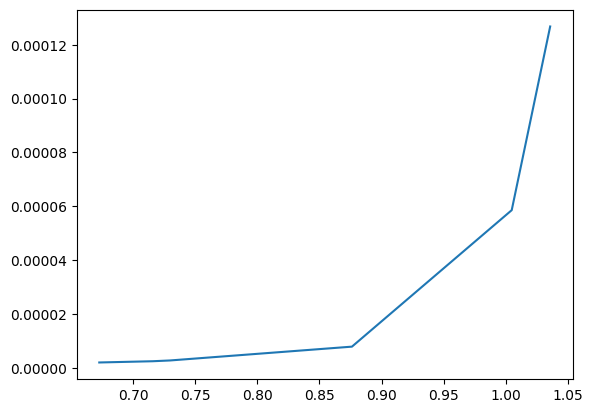

In [11]:
plt.plot(sigma_arr, energy_dct["absorbed_electrons"])

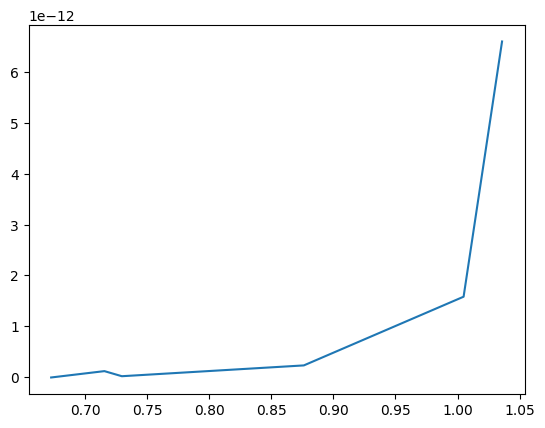

In [12]:
plt.plot(sigma_arr, impulse_dct["absorbed_electrons"])

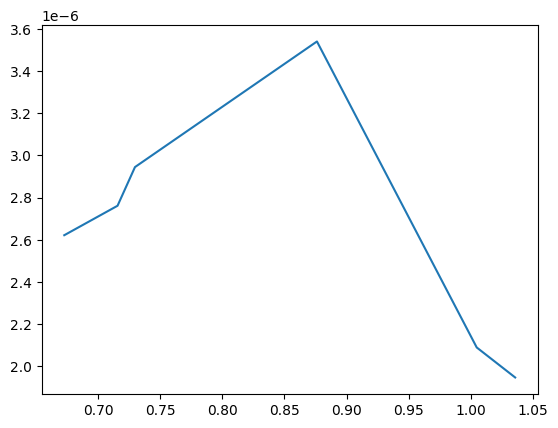

In [13]:
plt.plot(sigma_arr, energy_dct["absorbed_ions"])

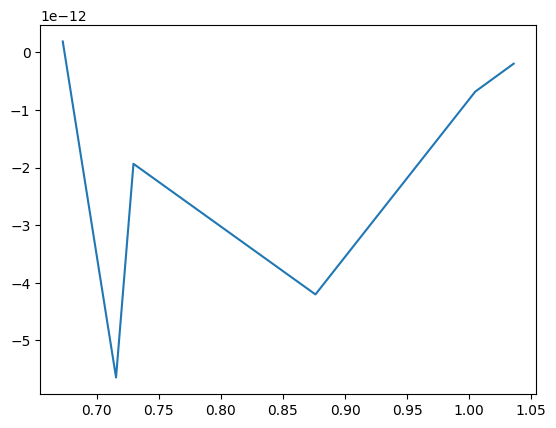

In [14]:
plt.plot(sigma_arr, impulse_dct["absorbed_ions"])

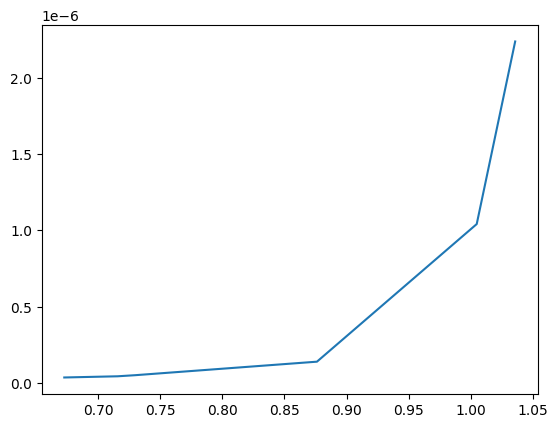

In [15]:
plt.plot(sigma_arr, energy_dct["secondary_electrons"])

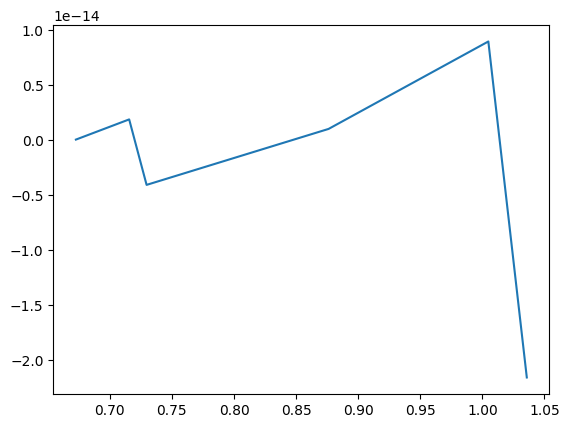

In [16]:
plt.plot(sigma_arr, impulse_dct["secondary_electrons"])